In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set the paths to your dataset folders
train_data_dir = '/content/drive/MyDrive/leaf_disease/tomato/train'
test_data_dir = '/content/drive/MyDrive/leaf_disease/tomato/val'

# Parameters
img_width, img_height = 224, 224
batch_size = 32
epochs = 10
num_classes = 10

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Build the GoogleNet (Inception v1) model
def inception_module(x, filters):
    conv1x1_1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv1x1_2 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv1x1_2)

    conv1x1_3 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv1x1_3)

    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    inception_output = concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_4], axis=-1)
    return inception_output

def googlenet(input_shape=(224, 224, 3), num_classes=1000):
    input_layer = Input(shape=input_shape)

    # Layer 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Layer 2
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Layer 3 - Inception module 1
    x = inception_module(x, [64, 128, 128, 128, 128, 32])

    # Layer 4 - Inception module 2
    x = inception_module(x, [128, 192, 96, 192, 128, 64])

    # Add more inception modules here as needed (You can follow the same pattern)

    # Layer 5
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)

    # Layer 6
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output Layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer, name='googlenet')
    return model

# Compile the model
google_net_model = googlenet(input_shape=(img_width, img_height, 3), num_classes=num_classes)
google_net_model.compile(optimizer=Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Print model summary
google_net_model.summary()

# Set up callbacks for training
checkpoint = ModelCheckpoint('leaf_disease_detection.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)

# Train the model
history = google_net_model.fit(train_generator,
                               steps_per_epoch=train_generator.samples // batch_size,
                               epochs=epochs,
                               validation_data=test_generator,
                               validation_steps=test_generator.samples // batch_size,
                               callbacks=[checkpoint, early_stopping])

# Save the model
google_net_model.save('final_leaf_disease_model.h5')

# Evaluate the model

Found 10006 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
   

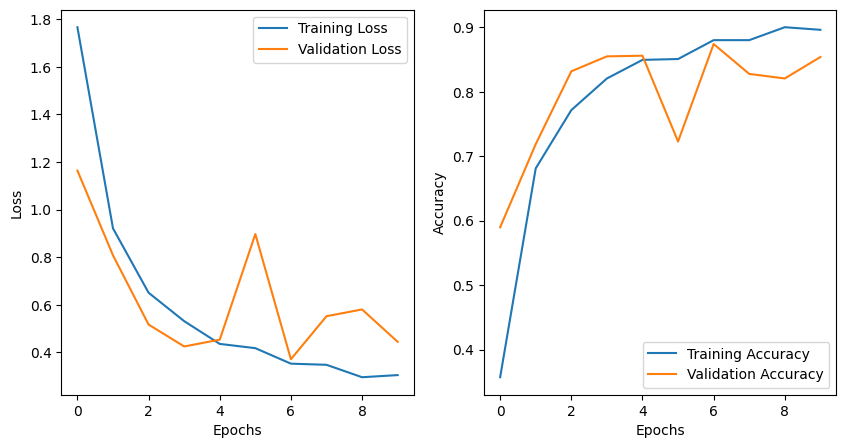

In [ ]:
# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Function to preprocess the input image and get the model's prediction
image_path = '/content/drive/MyDrive/leaf_disease/tomato/train/Tomato___Early_blight/01861c93-ea8b-4820-aaa8-cc6003b3e75b___RS_Erly.B 7855.JPG'
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_leaf_disease(image_path):
    processed_image = preprocess_image(image_path)
    prediction = google_net_model.predict(processed_image)
    class_index = np.argmax(prediction)
    class_labels = train_generator.class_indices
    for label, index in class_labels.items():
        if index == class_index:
            return label, prediction[0][class_index]

# Path to a specific image in the "yes" folder that you want to classify
specific_image_path = '/content/drive/MyDrive/leaf_disease/tomato/train/Tomato___Early_blight/01861c93-ea8b-4820-aaa8-cc6003b3e75b___RS_Erly.B 7855.JPG'
class_label, confidence = predict_leaf_disease(specific_image_path)
print(f"Class Label: {class_label}, Confidence: {confidence:.4f}")

1/1 [==============================] - 0s 33ms/step
Class Label: Tomato___Early_blight, Confidence: 0.9602
